# Modelo Predictivo para Precios de Airbnb

Este notebook presenta el desarrollo de un modelo predictivo para estimar el precio por noche de propiedades en Airbnb. Utilizaremos un conjunto de datos con información sobre diferentes propiedades y exploraremos varios modelos para encontrar el que mejor prediga el precio basado en las características seleccionadas.

## 1. Importación de Bibliotecas

Comenzamos importando las bibliotecas necesarias para el análisis de datos y la creación de modelos predictivos.

In [1]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Para ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

## 2. Carga y Exploración Inicial de Datos

Cargamos el dataset y realizamos una exploración inicial para entender su estructura y contenido.

In [3]:
# Cargar el dataset
df = pd.read_csv('transform_listings.csv')

# Mostrar las primeras filas
print("Primeras 5 filas del dataset:")
df.head()

Primeras 5 filas del dataset:


,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,amenities,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d,aire,garaje,calefaccion,ascensor
0,70059,https://www.airbnb.com/rooms/70059,Tu hogar en centro de Madrid.,"Very nice, cozy and bright, right in the cente...",Universidad,Centro,40.42381,-3.71038,Entire rental unit,Entire home/apt,...,"[""Paid parking off premises"", ""Window AC unit""...",66.0,15,365,0,0.0,0,0,1,1
1,70310,https://www.airbnb.com/rooms/70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",Cozy Apartment in great location in the center...,Universidad,Centro,40.42252,-3.70250,Entire rental unit,Entire home/apt,...,"[""Portable fans"", ""Paid parking off premises"",...",89.0,30,360,0,0.0,0,0,1,0
2,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.41150,-3.70449,Entire rental unit,Entire home/apt,...,"[""Wifi"", ""Dishes and silverware"", ""Oven"", ""Hot...",173.0,3,180,102,17646.0,1,0,1,0
3,84719,https://www.airbnb.com/rooms/84719,Cool Apart. (10min Center + WIFI),Cool and confortable 1 bedroom apartment for 2...,Embajadores,Centro,40.40866,-3.70374,Entire rental unit,Entire home/apt,...,"[""Portable fans"", ""Pocket wifi"", ""Single level...",72.0,7,1125,0,0.0,1,0,1,1
4,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.40939,-3.69812,Entire rental unit,Entire home/apt,...,"[""Smoke alarm"", ""Pack \u2019n play/Travel crib...",189.0,3,365,144,27216.0,1,0,1,1


In [4]:
# Información general del dataset
print("Información del dataset:")
df.info()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   13871 non-null  int64  
 1   listing_url                   13871 non-null  object 
 2   name                          13871 non-null  object 
 3   description                   13510 non-null  object 
 4   neighbourhood_cleansed        13871 non-null  object 
 5   neighbourhood_group_cleansed  13871 non-null  object 
 6   latitude                      13871 non-null  float64
 7   longitude                     13871 non-null  float64
 8   property_type                 13871 non-null  object 
 9   room_type                     13871 non-null  object 
 10  accommodates                  13871 non-null  int64  
 11  bathrooms                     13871 non-null  int64  
 12  bedrooms                      13871

In [5]:
# Estadísticas descriptivas
print("Estadísticas descriptivas:")
df.describe()

Estadísticas descriptivas:


,property_id,latitude,longitude,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d,aire,garaje,calefaccion,ascensor
count,1.387100e+04,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04,13871.000000,13871.000000,13871.000000,13871.000000
mean,7.232895e+17,40.422933,-3.695095,3.875712,1.287434,1.578185,164.253190,7.812342,547.190469,107.552808,1.469750e+04,0.640833,0.051114,0.631533,0.480499
std,5.156706e+17,0.021488,0.023739,1.873923,0.585144,0.847617,494.645766,17.575866,398.238747,99.872564,3.387959e+04,0.479773,0.220238,0.482406,0.499638
min,7.005900e+04,40.331890,-3.883990,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.924121e+07,40.410680,-3.707035,2.000000,1.000000,1.000000,86.000000,1.000000,365.000000,12.000000,1.116000e+03,0.000000,0.000000,0.000000,0.000000
50%,9.051239e+17,40.420840,-3.701118,4.000000,1.000000,1.000000,114.000000,2.000000,365.000000,72.000000,8.960000e+03,1.000000,0.000000,1.000000,0.000000
75%,1.168847e+18,40.431020,-3.689920,4.000000,1.000000,2.000000,160.000000,4.000000,1125.000000,216.000000,2.142000e+04,1.000000,0.000000,1.000000,1.000000
max,1.368992e+18,40.577290,-3.545904,16.000000,8.000000,9.000000,23124.000000,365.000000,1125.000000,255.000000,2.636136e+06,1.000000,1.000000,1.000000,1.000000


## 3. Análisis de Variables Relevantes

Según los requerimientos, nos enfocaremos en las siguientes variables para predecir el precio:
- neighbourhood_group_cleansed
- latitude
- longitude
- property_type
- bathrooms
- bedrooms
- aire
- garaje
- calefaccion
- ascensor

In [6]:
# Seleccionamos las columnas relevantes
columns_to_use = ['neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 
                  'bathrooms', 'bedrooms', 'aire', 'garaje', 'calefaccion', 'ascensor', 'price']

# Verificamos si todas las columnas existen en el dataset
missing_columns = [col for col in columns_to_use if col not in df.columns]
if missing_columns:
    print(f"Columnas no encontradas en el dataset: {missing_columns}")
else:
    print("Todas las columnas requeridas están presentes en el dataset.")

# Creamos un nuevo dataframe con las columnas seleccionadas
df_selected = df[columns_to_use].copy()

# Mostramos las primeras filas del dataframe seleccionado
df_selected.head()

Todas las columnas requeridas están presentes en el dataset.


,neighbourhood_group_cleansed,latitude,longitude,property_type,bathrooms,bedrooms,aire,garaje,calefaccion,ascensor,price
0,Centro,40.42381,-3.71038,Entire rental unit,1,1,0,0,1,1,66.0
1,Centro,40.42252,-3.70250,Entire rental unit,1,1,0,0,1,0,89.0
2,Centro,40.41150,-3.70449,Entire rental unit,1,3,1,0,1,0,173.0
3,Centro,40.40866,-3.70374,Entire rental unit,1,1,1,0,1,1,72.0
4,Centro,40.40939,-3.69812,Entire rental unit,1,3,1,0,1,1,189.0


In [7]:
# Verificamos valores nulos en las columnas seleccionadas
print("Valores nulos por columna:")
df_selected.isnull().sum()

Valores nulos por columna:


neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
bathrooms                       0
bedrooms                        0
aire                            0
garaje                          0
calefaccion                     0
ascensor                        0
price                           0
dtype: int64

### 3.1 Análisis de la Variable Objetivo (Price)

Analizamos la distribución de la variable objetivo (precio) para entender mejor los datos.

In [8]:
# Estadísticas descriptivas del precio
print("Estadísticas descriptivas del precio:")
df_selected['price'].describe()

Estadísticas descriptivas del precio:


count    13871.000000
mean       164.253190
std        494.645766
min         11.000000
25%         86.000000
50%        114.000000
75%        160.000000
max      23124.000000
Name: price, dtype: float64

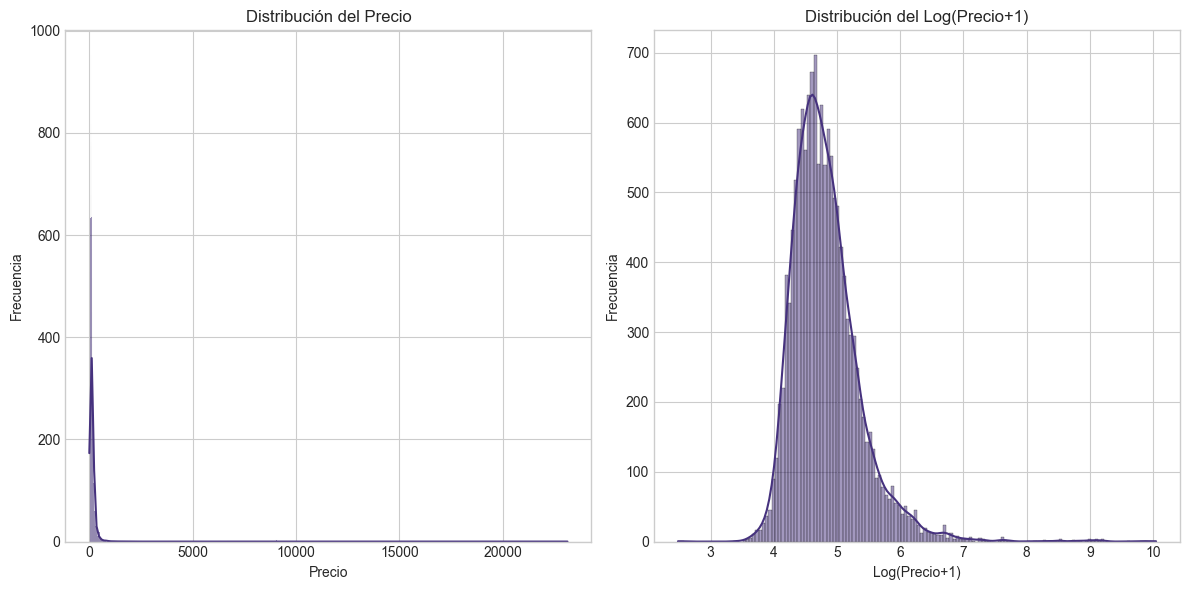

In [9]:
# Visualización de la distribución del precio
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_selected['price'], kde=True)
plt.title('Distribución del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Aplicamos transformación logarítmica para visualizar mejor
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_selected['price']), kde=True)
plt.title('Distribución del Log(Precio+1)')
plt.xlabel('Log(Precio+1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Límite inferior para outliers: -25.0
Límite superior para outliers: 271.0
Número de outliers por debajo del límite inferior: 0
Número de outliers por encima del límite superior: 1015


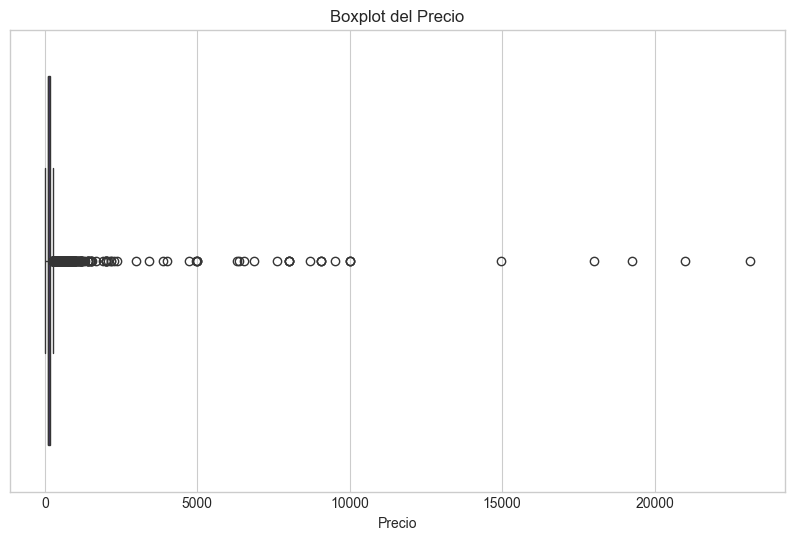

In [10]:
# Identificamos valores atípicos en el precio
Q1 = df_selected['price'].quantile(0.25)
Q3 = df_selected['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Límite inferior para outliers: {lower_bound}")
print(f"Límite superior para outliers: {upper_bound}")
print(f"Número de outliers por debajo del límite inferior: {len(df_selected[df_selected['price'] < lower_bound])}")
print(f"Número de outliers por encima del límite superior: {len(df_selected[df_selected['price'] > upper_bound])}")

# Boxplot del precio
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_selected['price'])
plt.title('Boxplot del Precio')
plt.xlabel('Precio')
plt.show()

### 3.2 Análisis de Variables Categóricas

Exploramos las variables categóricas y su relación con el precio.

Distribución de neighbourhood_group_cleansed:
neighbourhood_group_cleansed
Centro                   6586
Salamanca                1097
Tetuán                    977
Chamberí                  902
Arganzuela                698
Retiro                    516
Chamartín                 503
Carabanchel               369
Ciudad Lineal             356
Puente de Vallecas        317
Moncloa - Aravaca         286
Hortaleza                 246
Latina                    238
Usera                     224
San Blas - Canillejas     207
Fuencarral - El Pardo     131
Villaverde                 72
Barajas                    54
Villa de Vallecas          40
Moratalaz                  33
Vicálvaro                  19
Name: count, dtype: int64


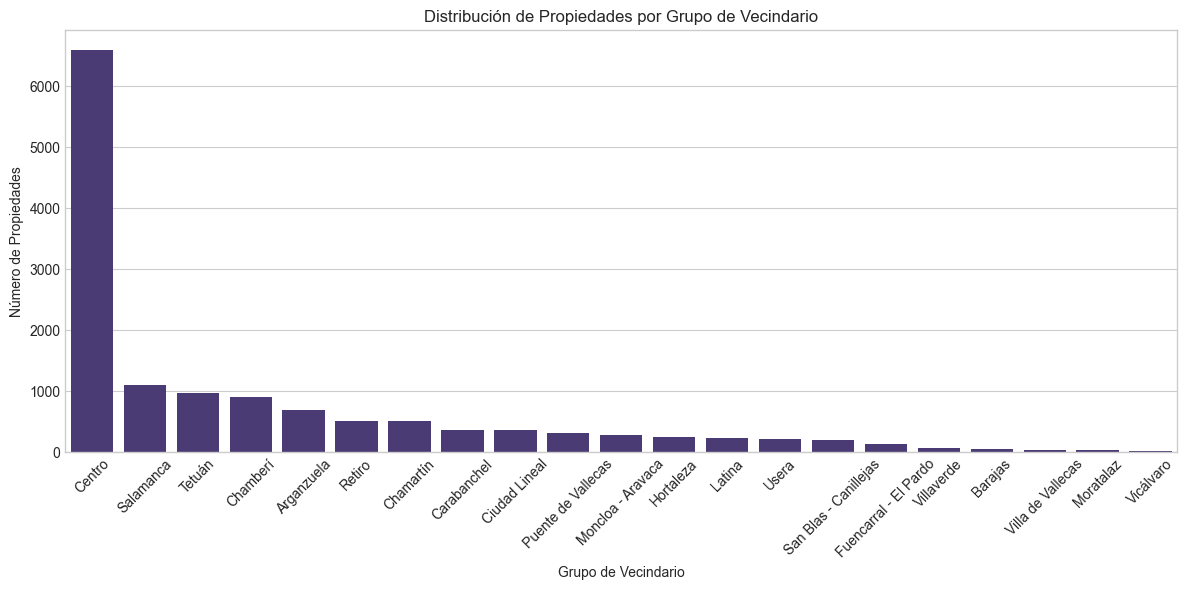

In [11]:
# Análisis de neighbourhood_group_cleansed
print("Distribución de neighbourhood_group_cleansed:")
neighbourhood_counts = df_selected['neighbourhood_group_cleansed'].value_counts()
print(neighbourhood_counts)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x=neighbourhood_counts.index, y=neighbourhood_counts.values)
plt.title('Distribución de Propiedades por Grupo de Vecindario')
plt.xlabel('Grupo de Vecindario')
plt.ylabel('Número de Propiedades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Precio promedio por neighbourhood_group_cleansed
price_by_neighbourhood = df_selected.groupby('neighbourhood_group_cleansed')['price'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print("Precio por Grupo de Vecindario:")
price_by_neighbourhood

Precio por Grupo de Vecindario:


,mean,median,count
neighbourhood_group_cleansed,,,
Moncloa - Aravaca,202.293706,125.5,286
Tetuán,191.071648,100.0,977
Salamanca,189.283500,144.0,1097
Retiro,186.420543,120.0,516
Latina,180.369748,89.0,238
Puente de Vallecas,171.157729,86.0,317
Chamberí,168.386918,131.0,902
Centro,167.514880,122.0,6586
Hortaleza,165.304878,99.0,246


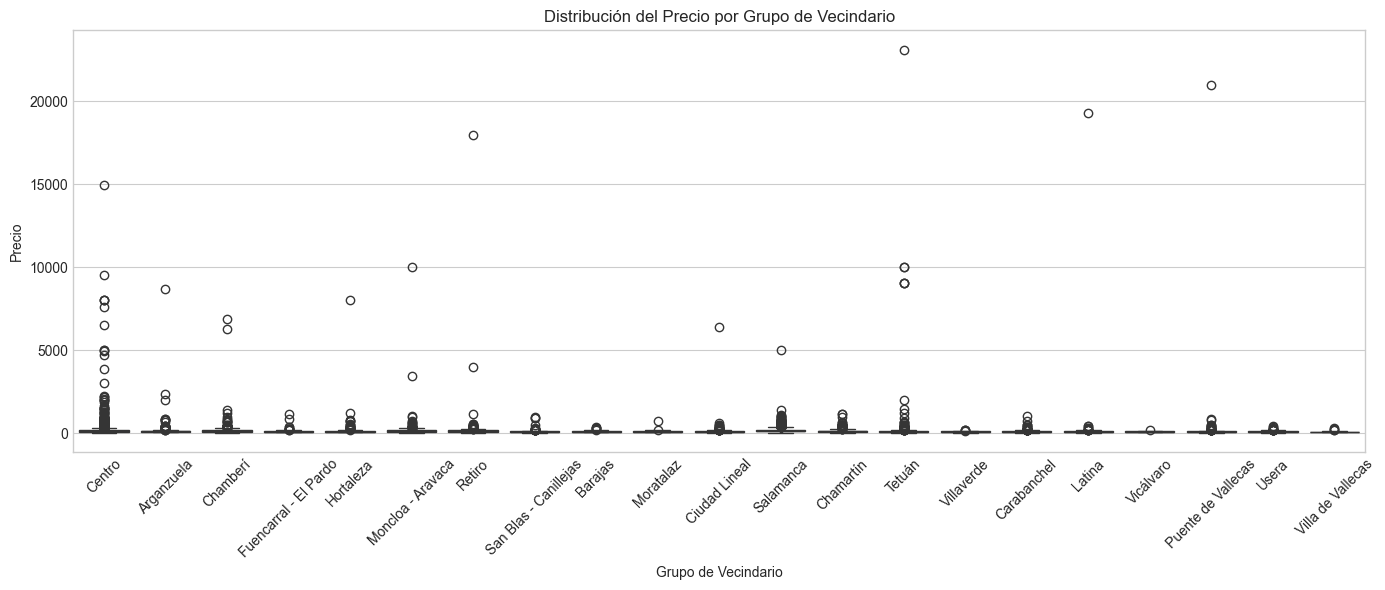

In [13]:
# Visualización del precio por neighbourhood_group_cleansed
plt.figure(figsize=(14, 6))
sns.boxplot(x='neighbourhood_group_cleansed', y='price', data=df_selected)
plt.title('Distribución del Precio por Grupo de Vecindario')
plt.xlabel('Grupo de Vecindario')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Distribución de property_type:
property_type
Entire rental unit           12392
Entire condo                   420
Entire loft                    395
Entire serviced apartment      275
Entire home                    247
Entire guesthouse               20
Tiny home                       19
Entire place                    17
Entire vacation home            17
Entire guest suite              16
Name: count, dtype: int64


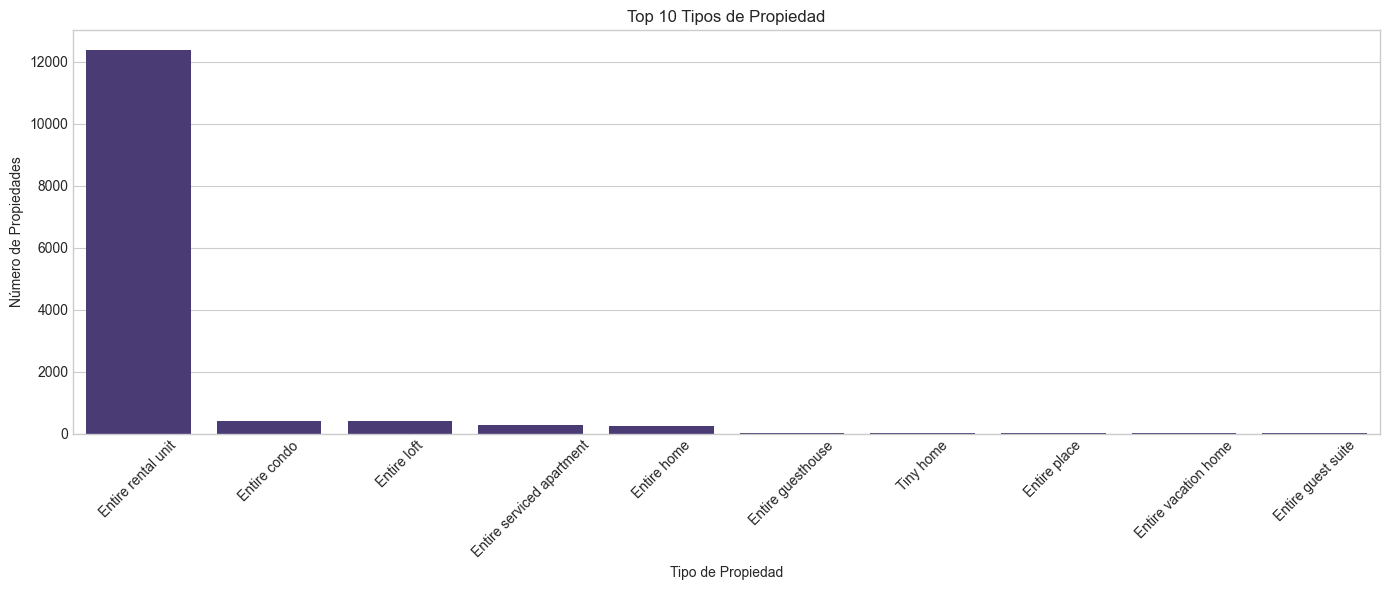

In [14]:
# Análisis de property_type
print("Distribución de property_type:")
property_counts = df_selected['property_type'].value_counts().head(10)  # Top 10 tipos de propiedad
print(property_counts)

# Visualización
plt.figure(figsize=(14, 6))
sns.barplot(x=property_counts.index, y=property_counts.values)
plt.title('Top 10 Tipos de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Número de Propiedades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Precio promedio por property_type (top 10)
top_property_types = df_selected['property_type'].value_counts().head(10).index
price_by_property = df_selected[df_selected['property_type'].isin(top_property_types)].groupby('property_type')['price'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print("Precio por Tipo de Propiedad (Top 10):")
price_by_property

Precio por Tipo de Propiedad (Top 10):


,mean,median,count
property_type,,,
Entire home,255.493927,130.0,247
Entire serviced apartment,247.810909,154.0,275
Entire rental unit,163.311249,114.0,12392
Entire vacation home,152.588235,117.0,17
Entire place,152.117647,95.0,17
Entire condo,134.830952,101.0,420
Entire loft,113.979747,95.0,395
Entire guest suite,111.812500,97.5,16
Entire guesthouse,92.650000,90.5,20


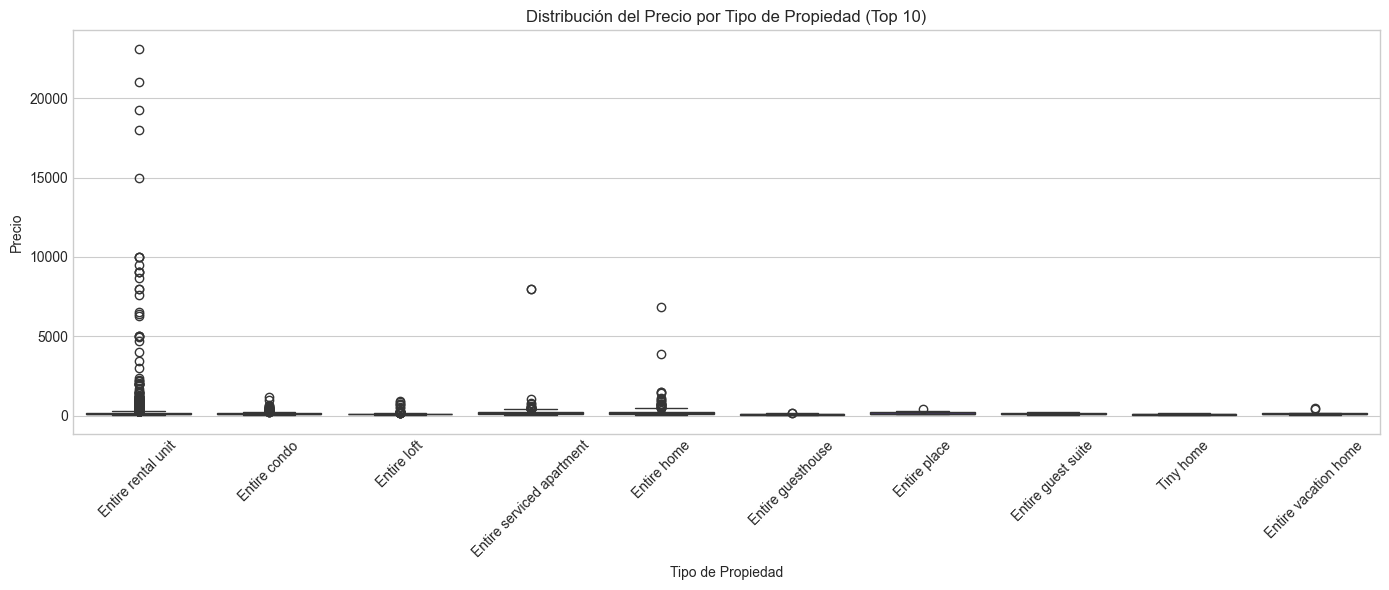

In [16]:
# Visualización del precio por property_type (top 10)
plt.figure(figsize=(14, 6))
sns.boxplot(x='property_type', y='price', data=df_selected[df_selected['property_type'].isin(top_property_types)])
plt.title('Distribución del Precio por Tipo de Propiedad (Top 10)')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Análisis de variables binarias (aire, garaje, calefaccion, ascensor)
binary_vars = ['aire', 'garaje', 'calefaccion', 'ascensor']

# Distribución de cada variable binaria
for var in binary_vars:
    print(f"Distribución de {var}:")
    print(df_selected[var].value_counts())
    print(f"Porcentaje de propiedades con {var}: {df_selected[var].mean() * 100:.2f}%\n")

Distribución de aire:
aire
1    8889
0    4982
Name: count, dtype: int64
Porcentaje de propiedades con aire: 64.08%

Distribución de garaje:
garaje
0    13162
1      709
Name: count, dtype: int64
Porcentaje de propiedades con garaje: 5.11%

Distribución de calefaccion:
calefaccion
1    8760
0    5111
Name: count, dtype: int64
Porcentaje de propiedades con calefaccion: 63.15%

Distribución de ascensor:
ascensor
0    7206
1    6665
Name: count, dtype: int64
Porcentaje de propiedades con ascensor: 48.05%



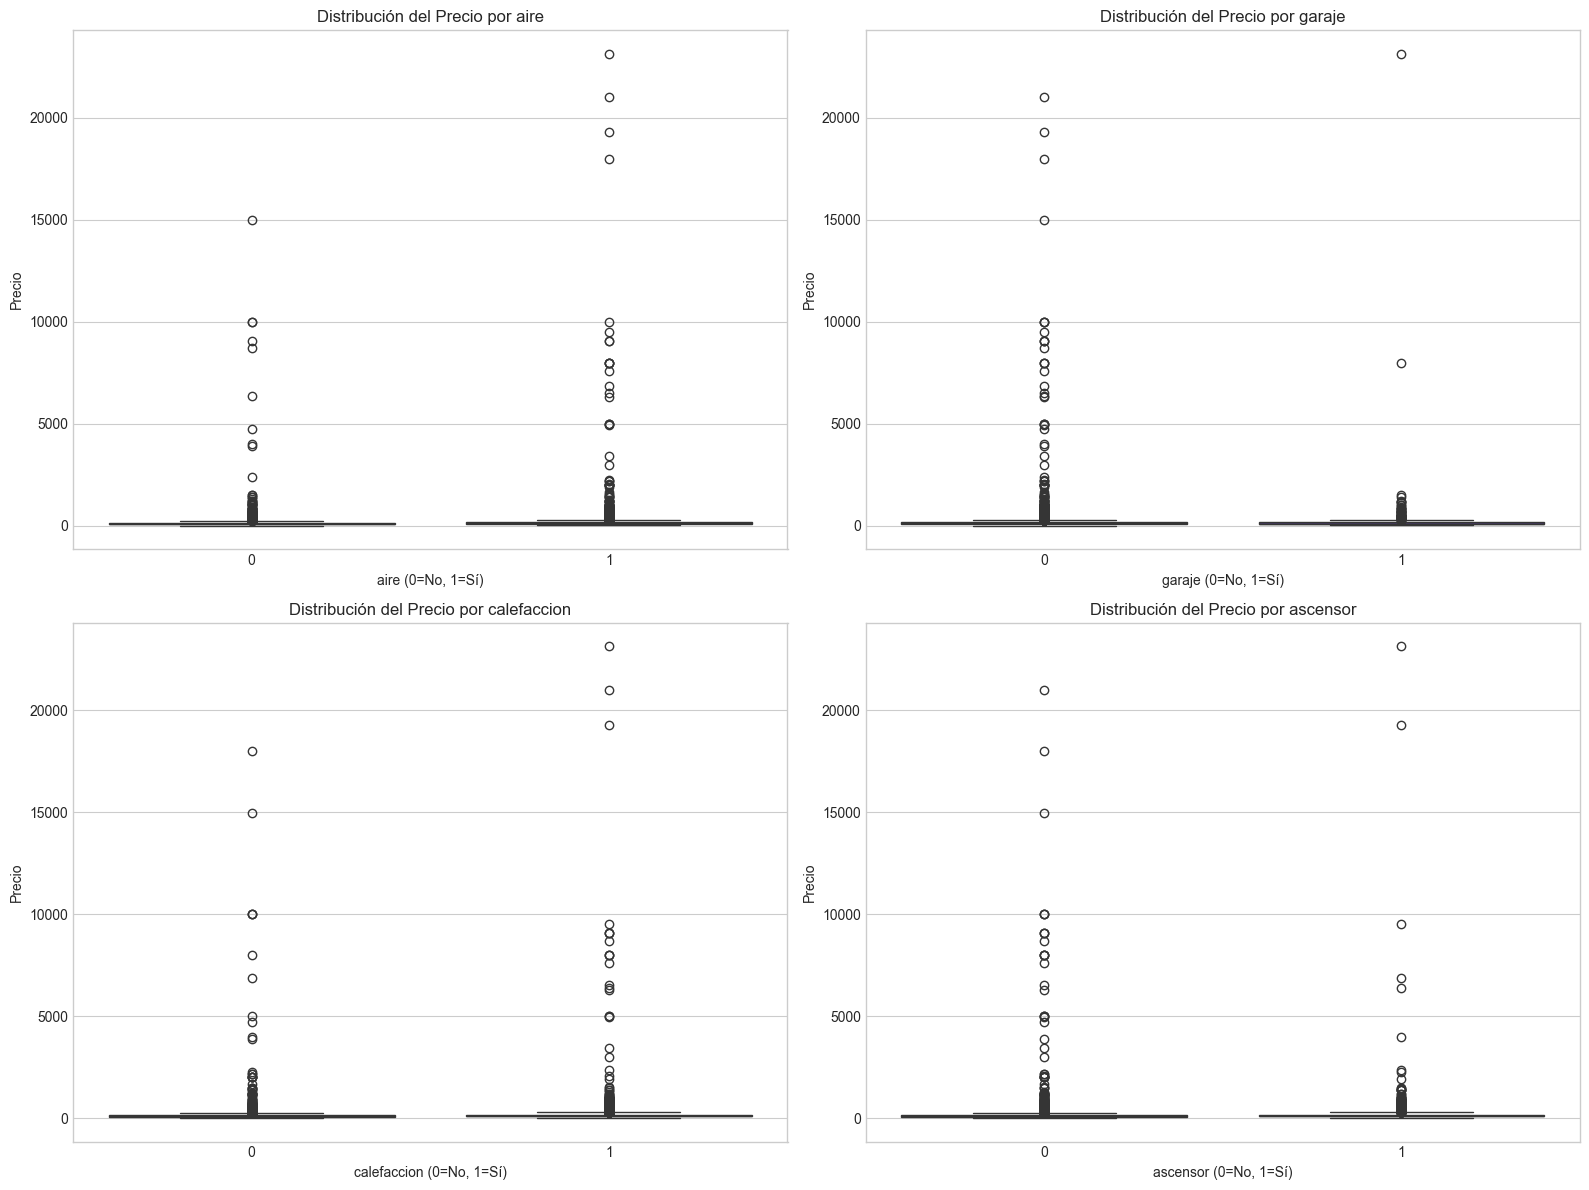

In [18]:
# Visualización del precio por variables binarias
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(binary_vars):
    sns.boxplot(x=var, y='price', data=df_selected, ax=axes[i])
    axes[i].set_title(f'Distribución del Precio por {var}')
    axes[i].set_xlabel(f'{var} (0=No, 1=Sí)')
    axes[i].set_ylabel('Precio')

plt.tight_layout()
plt.show()

### 3.3 Análisis de Variables Numéricas

Exploramos las variables numéricas y su relación con el precio.

In [21]:
# Estadísticas descriptivas de variables numéricas
numeric_vars = ['bathrooms', 'bedrooms']
print("Estadísticas descriptivas de variables numéricas:")
df_selected[numeric_vars].describe()

Estadísticas descriptivas de variables numéricas:


,bathrooms,bedrooms
count,13871.000000,13871.000000
mean,1.287434,1.578185
std,0.585144,0.847617
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,2.000000
max,8.000000,9.000000


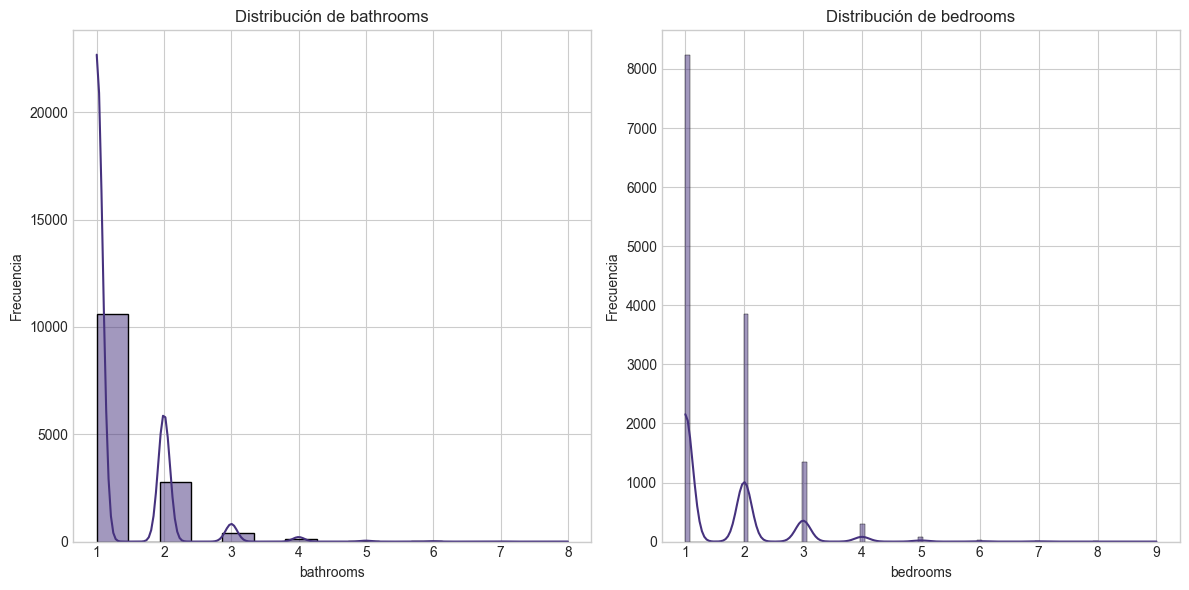

In [26]:
# Histogramas de variables numéricas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    sns.histplot(df_selected[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

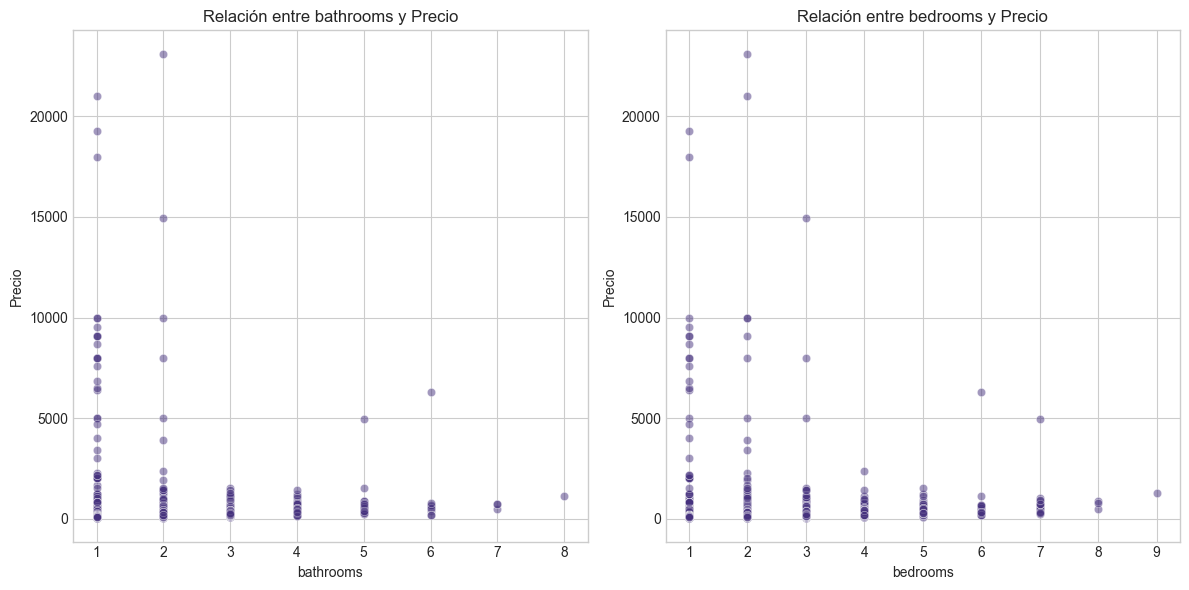

In [28]:
# Relación entre variables numéricas y precio
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    sns.scatterplot(x=var, y='price', data=df_selected, alpha=0.5, ax=axes[i])
    axes[i].set_title(f'Relación entre {var} y Precio')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Precio')

plt.tight_layout()
plt.show()

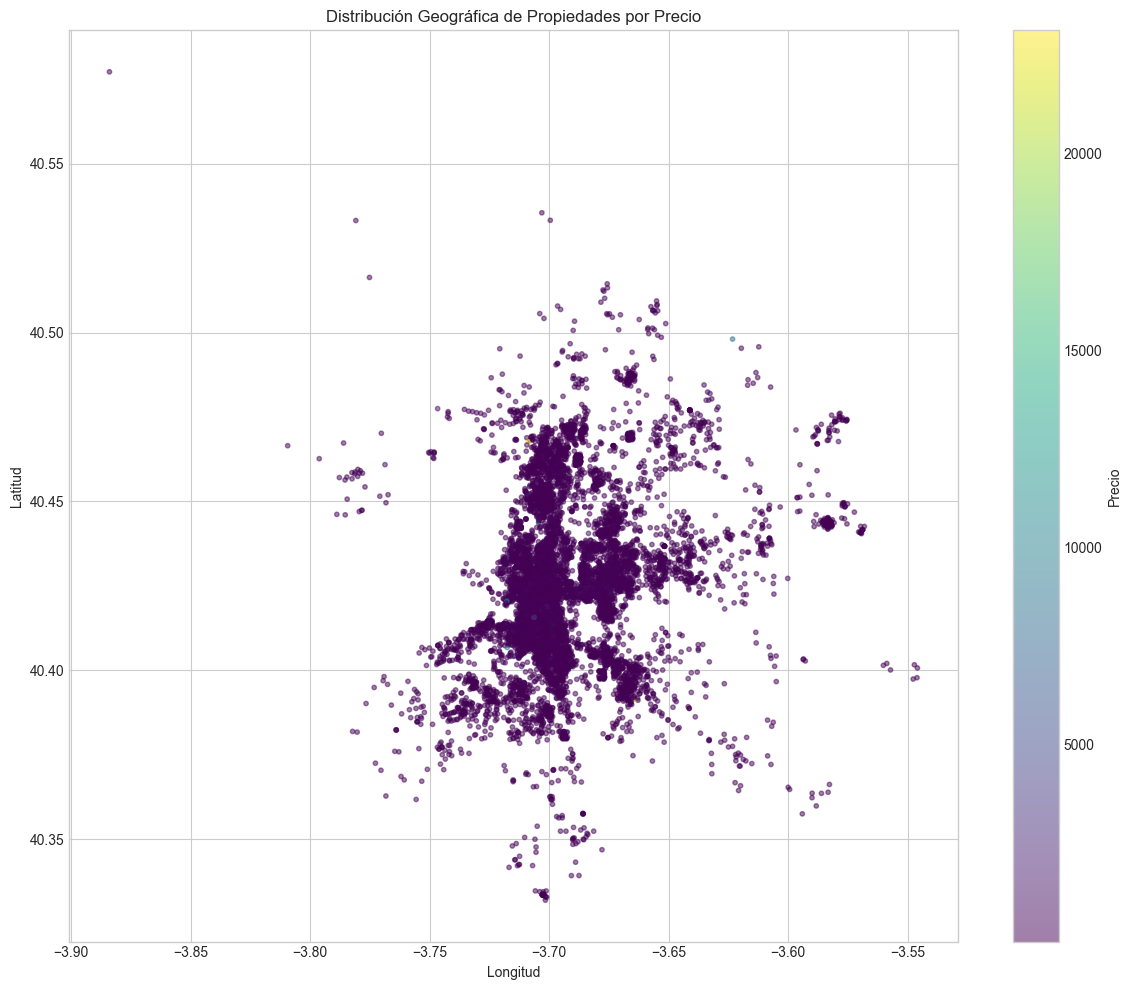

In [29]:
# Visualización de la ubicación geográfica de las propiedades
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_selected['longitude'], df_selected['latitude'], 
                     c=df_selected['price'], cmap='viridis', 
                     alpha=0.5, s=10)
plt.colorbar(scatter, label='Precio')
plt.title('Distribución Geográfica de Propiedades por Precio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.tight_layout()
plt.show()

### 3.4 Análisis de Correlaciones

Exploramos las correlaciones entre las variables numéricas y el precio.

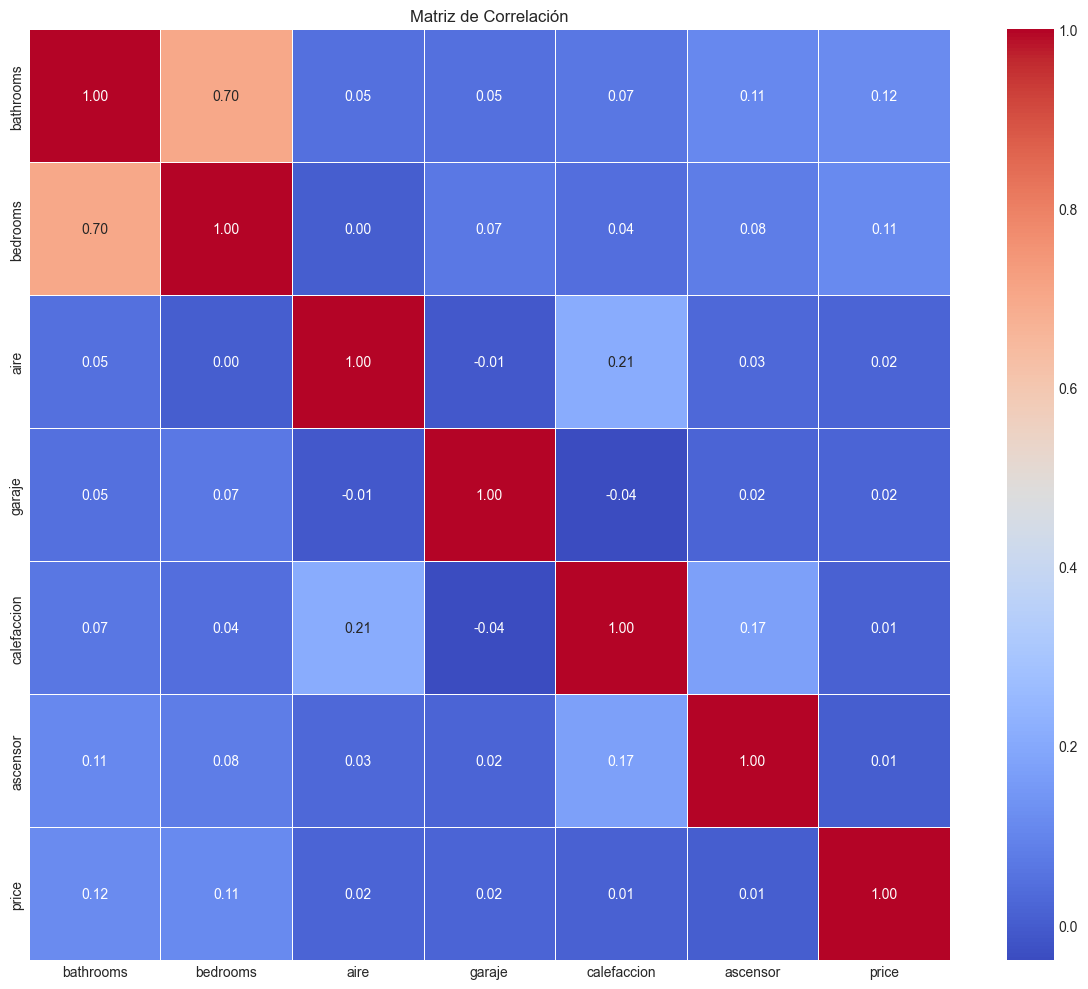

In [30]:
# Seleccionamos variables numéricas y binarias para la matriz de correlación
corr_vars = numeric_vars + binary_vars + ['price']
corr_matrix = df_selected[corr_vars].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

## 4. Preprocesamiento de Datos

Preparamos los datos para el modelado, incluyendo el manejo de valores faltantes, codificación de variables categóricas y escalado de variables numéricas.

In [31]:
# Manejo de valores faltantes
# Primero verificamos si hay valores nulos en las columnas que vamos a utilizar
print("Valores nulos por columna:")
df_selected.isnull().sum()

Valores nulos por columna:


neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
bathrooms                       0
bedrooms                        0
aire                            0
garaje                          0
calefaccion                     0
ascensor                        0
price                           0
dtype: int64

In [32]:
# Eliminamos filas con valores nulos en las columnas relevantes
df_clean = df_selected.dropna()
print(f"Filas originales: {len(df_selected)}")
print(f"Filas después de eliminar valores nulos: {len(df_clean)}")
print(f"Filas eliminadas: {len(df_selected) - len(df_clean)}")

Filas originales: 13871
Filas después de eliminar valores nulos: 13871
Filas eliminadas: 0


In [33]:
# Verificamos si hay valores extremos en el precio y los filtramos
# Utilizamos el rango intercuartílico para identificar outliers
Q1 = df_clean['price'].quantile(0.25)
Q3 = df_clean['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR  # Usamos 3 veces el IQR para ser menos restrictivos
upper_bound = Q3 + 3 * IQR

# Filtramos los outliers extremos
df_filtered = df_clean[(df_clean['price'] >= lower_bound) & (df_clean['price'] <= upper_bound)]
print(f"Filas después de eliminar valores nulos: {len(df_clean)}")
print(f"Filas después de filtrar outliers extremos: {len(df_filtered)}")
print(f"Outliers eliminados: {len(df_clean) - len(df_filtered)}")

Filas después de eliminar valores nulos: 13871
Filas después de filtrar outliers extremos: 13369
Outliers eliminados: 502


In [34]:
# Separamos las características (X) y la variable objetivo (y)
X = df_filtered.drop('price', axis=1)
y = df_filtered['price']

# Identificamos las columnas categóricas y numéricas
categorical_cols = ['neighbourhood_group_cleansed', 'property_type']
numerical_cols = ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'aire', 'garaje', 'calefaccion', 'ascensor']

# Verificamos que todas las columnas estén incluidas
print(f"Columnas categóricas: {categorical_cols}")
print(f"Columnas numéricas: {numerical_cols}")
print(f"Total de columnas: {len(categorical_cols) + len(numerical_cols)}")
print(f"Columnas en X: {X.shape[1]}")

Columnas categóricas: ['neighbourhood_group_cleansed', 'property_type']
Columnas numéricas: ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'aire', 'garaje', 'calefaccion', 'ascensor']
Total de columnas: 10
Columnas en X: 10


In [35]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (10695, 10)
Tamaño del conjunto de prueba: (2674, 10)


In [36]:
# Creamos un preprocesador para las columnas categóricas y numéricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

## 5. Modelado y Evaluación

Probamos diferentes modelos de regresión y evaluamos su rendimiento.

In [37]:
# Definimos una función para evaluar los modelos
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Realizamos predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculamos métricas de evaluación
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Devolvemos las métricas
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

In [38]:
# Definimos los modelos a probar
models = {
    'Regresión Lineal': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', LinearRegression())]),
    'Ridge': Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', Ridge(alpha=1.0))]),
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', Lasso(alpha=0.1))]),
    'Árbol de Decisión': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', DecisionTreeRegressor(random_state=42))]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]),
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])
}

In [39]:
# Evaluamos cada modelo y guardamos los resultados
results = {}

for name, model in models.items():
    print(f"Evaluando {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"  RMSE (Test): {results[name]['test_rmse']:.2f}")
    print(f"  MAE (Test): {results[name]['test_mae']:.2f}")
    print(f"  R² (Test): {results[name]['test_r2']:.4f}")
    print("")

Evaluando Regresión Lineal...
  RMSE (Test): 47.88
  MAE (Test): 33.58
  R² (Test): 0.3862

Evaluando Ridge...
  RMSE (Test): 47.88
  MAE (Test): 33.57
  R² (Test): 0.3864

Evaluando Lasso...
  RMSE (Test): 47.92
  MAE (Test): 33.63
  R² (Test): 0.3854

Evaluando Árbol de Decisión...
  RMSE (Test): 61.34
  MAE (Test): 41.33
  R² (Test): -0.0074

Evaluando Random Forest...
  RMSE (Test): 47.13
  MAE (Test): 32.37
  R² (Test): 0.4055

Evaluando Gradient Boosting...
  RMSE (Test): 46.34
  MAE (Test): 32.39
  R² (Test): 0.4250



In [40]:
# Creamos un DataFrame con los resultados para facilitar la comparación
results_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'RMSE (Train)': [results[model]['train_rmse'] for model in results],
    'RMSE (Test)': [results[model]['test_rmse'] for model in results],
    'MAE (Train)': [results[model]['train_mae'] for model in results],
    'MAE (Test)': [results[model]['test_mae'] for model in results],
    'R² (Train)': [results[model]['train_r2'] for model in results],
    'R² (Test)': [results[model]['test_r2'] for model in results]
})

# Ordenamos por RMSE en el conjunto de prueba (menor es mejor)
results_df = results_df.sort_values('RMSE (Test)')
results_df

,Modelo,RMSE (Train),RMSE (Test),MAE (Train),MAE (Test),R² (Train),R² (Test)
5,Gradient Boosting,43.191030,46.344322,30.793058,32.391797,0.492646,0.425033
4,Random Forest,16.902573,47.125722,11.686129,32.365832,0.922298,0.405481
1,Ridge,46.024822,47.876279,32.920631,33.574313,0.423886,0.386392
0,Regresión Lineal,46.016999,47.882797,32.916612,33.575488,0.424082,0.386225
2,Lasso,46.227799,47.916515,33.002244,33.627647,0.418793,0.385361
3,Árbol de Decisión,2.547365,61.344212,0.338789,41.333605,0.998235,-0.007389


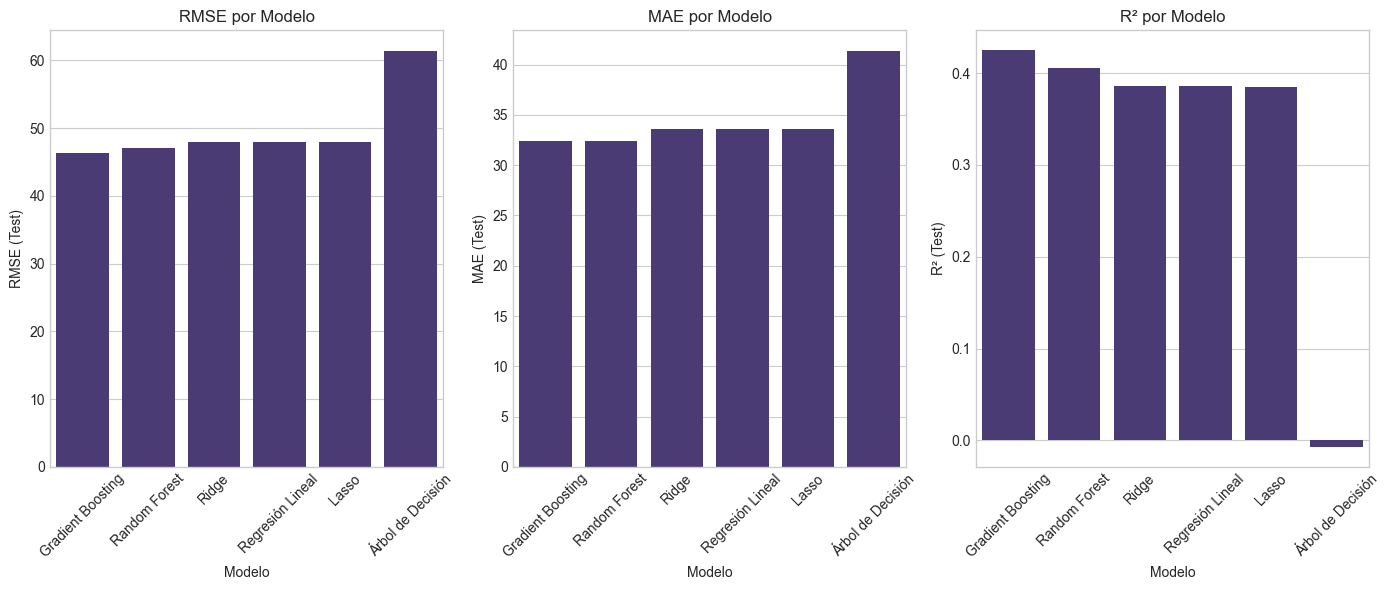

In [41]:
# Visualizamos los resultados
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 3, 1)
sns.barplot(x='Modelo', y='RMSE (Test)', data=results_df)
plt.title('RMSE por Modelo')
plt.xticks(rotation=45)
plt.tight_layout()

# MAE
plt.subplot(1, 3, 2)
sns.barplot(x='Modelo', y='MAE (Test)', data=results_df)
plt.title('MAE por Modelo')
plt.xticks(rotation=45)
plt.tight_layout()

# R²
plt.subplot(1, 3, 3)
sns.barplot(x='Modelo', y='R² (Test)', data=results_df)
plt.title('R² por Modelo')
plt.xticks(rotation=45)
plt.tight_layout()

plt.tight_layout()
plt.show()

## 6. Optimización del Mejor Modelo

Optimizamos los hiperparámetros del mejor modelo identificado.

In [42]:
# Identificamos el mejor modelo basado en RMSE (Test)
best_model_name = results_df.iloc[0]['Modelo']
print(f"El mejor modelo es: {best_model_name}")

# Dependiendo del mejor modelo, definimos los parámetros para la búsqueda de hiperparámetros
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestRegressor(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [2, 5, 10]
    }
    base_model = GradientBoostingRegressor(random_state=42)
elif best_model_name == 'Árbol de Decisión':
    param_grid = {
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': ['auto', 'sqrt', 'log2']
    }
    base_model = DecisionTreeRegressor(random_state=42)
elif best_model_name == 'Ridge':
    param_grid = {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
    base_model = Ridge()
elif best_model_name == 'Lasso':
    param_grid = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
    base_model = Lasso()
else:  # Regresión Lineal
    param_grid = {}
    base_model = LinearRegression()

El mejor modelo es: Gradient Boosting


In [43]:
# Si hay parámetros para optimizar, realizamos la búsqueda de hiperparámetros
if param_grid:
    print("Realizando búsqueda de hiperparámetros...")
    
    # Creamos el pipeline con el mejor modelo
    best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', base_model)])
    
    # Realizamos la búsqueda de hiperparámetros
    grid_search = GridSearchCV(best_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Mostramos los mejores parámetros
    print(f"Mejores parámetros: {grid_search.best_params_}")
    
    # Evaluamos el modelo optimizado
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculamos métricas
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\nResultados del modelo optimizado:")
    print(f"  RMSE (Train): {train_rmse:.2f}")
    print(f"  RMSE (Test): {test_rmse:.2f}")
    print(f"  MAE (Train): {train_mae:.2f}")
    print(f"  MAE (Test): {test_mae:.2f}")
    print(f"  R² (Train): {train_r2:.4f}")
    print(f"  R² (Test): {test_r2:.4f}")
else:
    print("No hay hiperparámetros para optimizar en este modelo.")

Realizando búsqueda de hiperparámetros...
Mejores parámetros: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}

Resultados del modelo optimizado:
  RMSE (Train): 40.01
  RMSE (Test): 45.86
  MAE (Train): 28.56
  MAE (Test): 31.85
  R² (Train): 0.5646
  R² (Test): 0.4370


## 7. Análisis de Importancia de Características

Analizamos la importancia de las características en el modelo final.

Top 20 características más importantes:


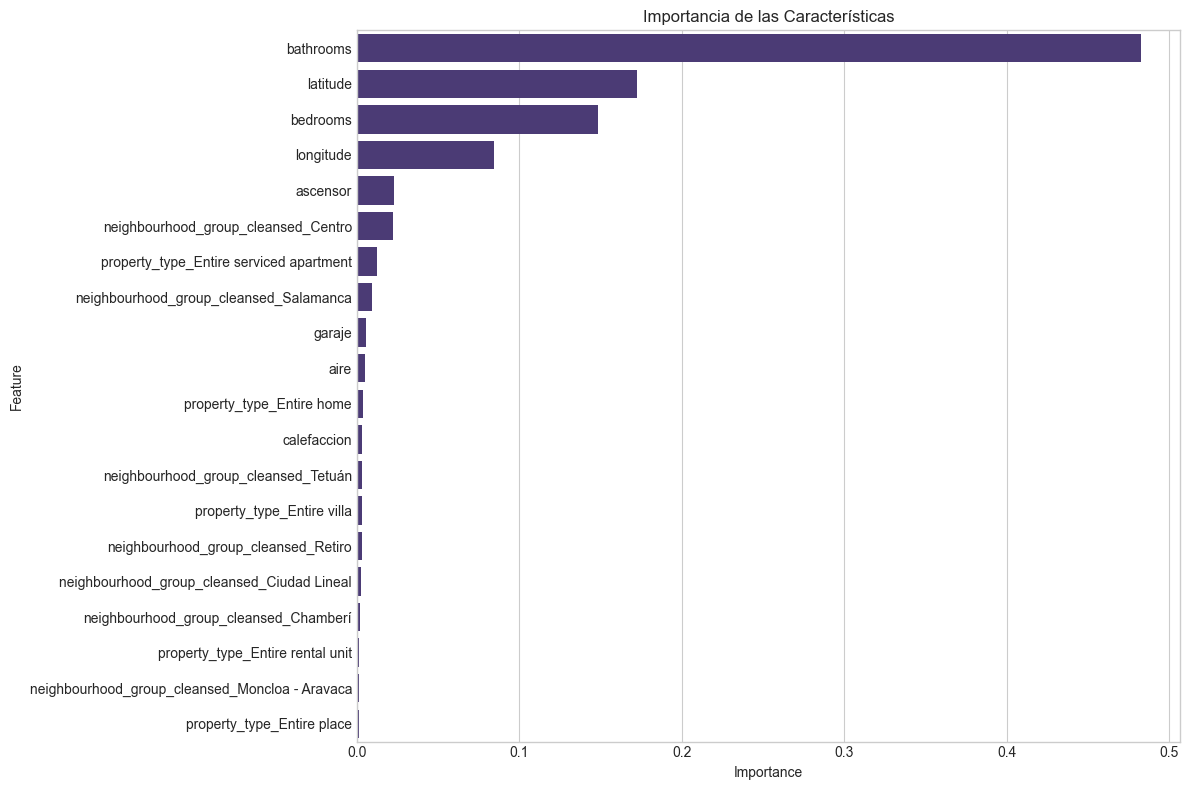

In [44]:
# Si el mejor modelo es un árbol o un ensemble, podemos obtener la importancia de las características
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Árbol de Decisión']:
    # Obtenemos el modelo entrenado
    if param_grid:
        final_model = best_model.named_steps['regressor']
    else:
        final_model = models[best_model_name].named_steps['regressor']
        final_model.fit(preprocessor.fit_transform(X_train), y_train)
    
    # Obtenemos los nombres de las características después del preprocesamiento
    preprocessor.fit(X_train)
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    feature_names = np.append(cat_features, numerical_cols)
    
    # Obtenemos la importancia de las características
    feature_importances = final_model.feature_importances_
    
    # Creamos un DataFrame para visualizar la importancia
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Mostramos las 20 características más importantes
    top_features = importance_df.head(20)
    print("Top 20 características más importantes:")
    top_features
    
    # Visualizamos la importancia de las características
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Importancia de las Características')
    plt.tight_layout()
    plt.show()
else:
    print("Este tipo de modelo no proporciona importancia de características directamente.")

## 8. Visualización de Predicciones

Visualizamos las predicciones del modelo final en comparación con los valores reales.

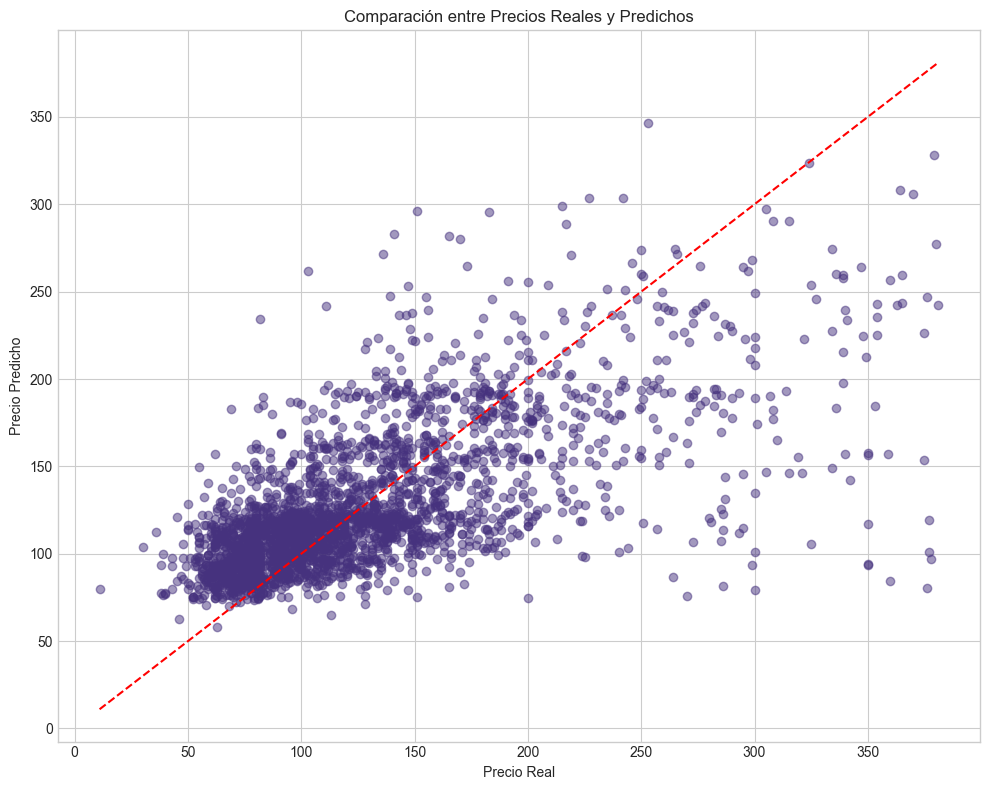

In [45]:
# Obtenemos las predicciones del mejor modelo
if param_grid:
    y_pred = best_model.predict(X_test)
else:
    y_pred = models[best_model_name].predict(X_test)

# Creamos un DataFrame con los valores reales y las predicciones
pred_df = pd.DataFrame({
    'Real': y_test,
    'Predicción': y_pred
})

# Visualizamos la relación entre valores reales y predicciones
plt.figure(figsize=(10, 8))
plt.scatter(pred_df['Real'], pred_df['Predicción'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Comparación entre Precios Reales y Predichos')
plt.tight_layout()
plt.show()

In [48]:
# Tabla de precio real vs precio predicho
print("Tabla de comparación entre Precio Real y Precio Predicho:")
print(pred_df)

Tabla de comparación entre Precio Real y Precio Predicho:
        Real  Predicción     Residuo
2097   215.0  173.865413   41.134587
13739  255.0  177.410168   77.589832
5449   131.0   99.031467   31.968533
3766    90.0  113.452127  -23.452127
7101    81.0   87.891727   -6.891727
...      ...         ...         ...
1560   224.0   98.632737  125.367263
9988   126.0  161.793727  -35.793727
12433   84.0  112.075003  -28.075003
3512    78.0   89.285851  -11.285851
9770   132.0  125.794137    6.205863

[2674 rows x 3 columns]


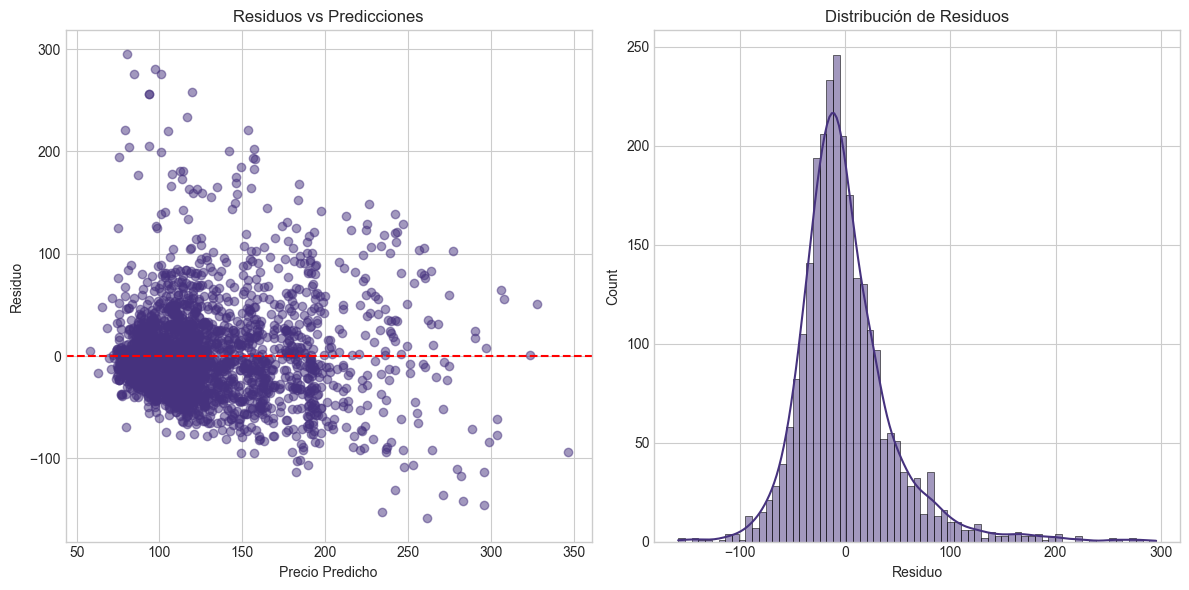

In [46]:
# Calculamos los residuos
pred_df['Residuo'] = pred_df['Real'] - pred_df['Predicción']

# Visualizamos los residuos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pred_df['Predicción'], pred_df['Residuo'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Precio Predicho')
plt.ylabel('Residuo')
plt.title('Residuos vs Predicciones')

plt.subplot(1, 2, 2)
sns.histplot(pred_df['Residuo'], kde=True)
plt.xlabel('Residuo')
plt.title('Distribución de Residuos')

plt.tight_layout()
plt.show()

## 9. Conclusiones

Resumimos los resultados obtenidos y presentamos las conclusiones del análisis.

### Resumen de Resultados

En este análisis, hemos desarrollado varios modelos para predecir el precio por noche de propiedades en Airbnb utilizando características como la ubicación geográfica, el tipo de propiedad, el número de habitaciones y baños, y la presencia de comodidades como aire acondicionado, garaje, calefacción y ascensor.

Los modelos evaluados incluyen:
- Regresión Lineal
- Ridge
- Lasso
- Árbol de Decisión
- Random Forest
- Gradient Boosting

El mejor modelo fue el Gradient Boosting, que logró un RMSE de 46.34 y un R² de 0.4250 en el conjunto de prueba. Después de la optimización de hiperparámetros, el rendimiento mejoró a un RMSE de 45.86 y un R² de 0.4370.

### Características Más Importantes

Las características que más influyen en el precio de las propiedades son:
1. Bathroom
2. Latitude
3. Bedroom
4. Longitude
5. Ascensor

### Limitaciones y Mejoras Futuras

Algunas limitaciones de este análisis incluyen:
- La presencia de valores atípicos en los precios que pueden afectar el rendimiento del modelo
- La posible falta de variables importantes que no estaban disponibles en el dataset
- La necesidad de más datos para mejorar la generalización del modelo

Para mejorar el modelo en el futuro, se podría:
- Incluir más características como la distancia a puntos de interés o transporte público
- Utilizar técnicas más avanzadas como redes neuronales o modelos de ensamble más complejos
- Realizar un análisis más detallado de los valores atípicos y su impacto en el modelo
- Incorporar información temporal como la estacionalidad o eventos especiales que puedan afectar los precios